<a href="https://colab.research.google.com/github/FANJIYU0825/Retrieval-question/blob/master/PLMBaseballqa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 檢索製作

In [ ]:
#下載資料集
!wget https://www.dropbox.com/s/0egaxe34hktnlyn/baseball_sample%285%29.json?dl=0 -O baseball_samle5.json
!pip install pyserini
!pip install faiss-cpu

--2022-08-06 17:15:51--  https://www.dropbox.com/s/0egaxe34hktnlyn/baseball_sample%285%29.json?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/0egaxe34hktnlyn/baseball_sample%285%29.json [following]
--2022-08-06 17:15:51--  https://www.dropbox.com/s/raw/0egaxe34hktnlyn/baseball_sample%285%29.json
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4f1cc7513a5ed6f2383790b2dd.dl.dropboxusercontent.com/cd/0/inline/Bqj6Sg-t7V1zzxuTy9D5klycQfD6ExKa4sglQtJTS8R0nw2gMBGsOB8Yx7ztF1gw2-Ef7gJtpS4h1kTmiQw9n-BZBo85rKrsuWRZh6QxOMvW4KJGZeVA7NRxe-g6otHYVD_THBxYMzhMc4axK6kk8TUdE72n3ALYoB6LKYisnaeiZw/file# [following]
--2022-08-06 17:15:52--  https://uc4f1cc7513a5ed6f2383790b2dd.dl.dropboxusercontent.com/cd/0/inline/Bqj6Sg-t7V1zzxuTy9

In [ ]:
sys_dir = "/content/drive/My Drive/ColabNotebooks/wikigroach/Baseball_Wiki/qa"
#連接並mount自己的雲端硬碟(點選跑出網址複製最後的授權碼貼上並執行)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#切換執行目錄
# sys_dir = "content/wikigroach/Baseball_Wiki/qa"
import os
if not os.path.isdir(sys_dir):
    os.mkdir(sys_dir)
os.chdir(sys_dir)


Mounted at /content/drive


In [ ]:
#引入套件
import requests
import re
import time
import json
from bs4 import BeautifulSoup
#from fake_useragent import UserAgent
import datetime
import pandas
import base64
import urllib.parse
from pathlib import Path
import numpy
with open('baseball_samle5.json') as f:
    bbq = json.load(f)

In [ ]:
Corpus=[]
for docc in bbq.values():

  for cont in docc['contents']['content']:
    texts=[x for x in cont['sections'] if x['type']=='text']

    for ttx in texts:

      if 'data' in ttx:
        #把原本很長的文字拆解成許多小段落,藉以符合Retriver的需求
        rst=ttx['data'].split('。')
        for r in rst:
          #若是這段落超過5個字才納入處理
          if(len(r)>5):

            #收集和這段落有關的關鍵字
            hihi=[h[0] for h in docc['contents']['highlights'] if h[0] in r and len(h[0])>1]
            hihi=list(set(hihi))
            
            #串聯文本、段落標題和主題,藉此提高搜尋的多樣化
            r=r+","+cont['subject']+","+docc['contents']['title']

            khihi=[]
            khihi.append(cont['subject'])
            for hi in hihi :
              bbqo={}
              #假造答案
              bbqo['answer']=hi
              bbqo['context']=r
              if hi in ttx['data']:
                khihi.append(hi)
            bbqo['question']=",".join(khihi)
            #假造問題
            
            Corpus.append(bbqo)

In [ ]:
#整理文檔集合
temp_list=[]
for id, doc in enumerate(Corpus):
  temp_list.append(doc["context"])

json_corpus=[]
for id, doc in enumerate(set(temp_list)):
  json_corpus.append({"id":id,"contents":doc})


import json
with open('/content/format_for_pyserini.json', 'w', encoding='utf-8') as f:
    json.dump(json_corpus, f, ensure_ascii=False, indent=4)

In [ ]:
#建立Retriver索引
!python -m pyserini.index.lucene \
  --collection JsonCollection \
  --input corpus \
  --language zh \
  --index Index/Wiki_Chinese \
  --generator DefaultLuceneDocumentGenerator \
  --threads 1 \
  --storePositions --storeDocvectors --storeRaw

2022-08-06 17:24:07,731 INFO  [main] index.IndexCollection (IndexCollection.java:645) - Setting log level to INFO
2022-08-06 17:24:07,733 INFO  [main] index.IndexCollection (IndexCollection.java:648) - Starting indexer...
2022-08-06 17:24:07,734 INFO  [main] index.IndexCollection (IndexCollection.java:649) - ============ Loading Parameters ============
2022-08-06 17:24:07,734 INFO  [main] index.IndexCollection (IndexCollection.java:650) - DocumentCollection path: corpus
2022-08-06 17:24:07,735 INFO  [main] index.IndexCollection (IndexCollection.java:651) - CollectionClass: JsonCollection
2022-08-06 17:24:07,735 INFO  [main] index.IndexCollection (IndexCollection.java:652) - Generator: DefaultLuceneDocumentGenerator
2022-08-06 17:24:07,736 INFO  [main] index.IndexCollection (IndexCollection.java:653) - Threads: 1
2022-08-06 17:24:07,736 INFO  [main] index.IndexCollection (IndexCollection.java:654) - Language: zh
2022-08-06 17:24:07,737 INFO  [main] index.IndexCollection (IndexCollection

In [ ]:
from pyserini.search.lucene import LuceneSearcher
from pyserini.index import IndexReader


searcher = LuceneSearcher('Index/Wiki_Chinese')
index_reader = IndexReader('Index/Wiki_Chinese')

def Retreiver(quesion):
  searcher.set_language('zh')
  hits = searcher.search(quesion)
  return json.loads(searcher.doc(hits[0].docid).raw())["contents"]


# 數據視覺化

In [ ]:
!pip install -q transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("nyust-eb210/braslab-bert-drcd-384")
model = AutoModelForQuestionAnswering.from_pretrained("nyust-eb210/braslab-bert-drcd-384").to(device)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def simplescore(text, query):
  
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  tokenizer = AutoTokenizer.from_pretrained("nyust-eb210/braslab-bert-drcd-384")
  model = AutoModelForQuestionAnswering.from_pretrained("nyust-eb210/braslab-bert-drcd-384").to(device)
  encoded_input = tokenizer(text, query, return_tensors="pt").to(device)

  input_id=encoded_input.input_ids.tolist()[0]

  tokens=tokenizer.convert_ids_to_tokens(input_id)

  output = model(**encoded_input)

  start = output.start_logits
  end =   output.end_logits

  # make sure torch.cuda is GPU or CPU
  if torch.cuda.is_available()==1:

    s_scores = start.detach().cpu().numpy().flatten()
    e_scores = end.detach().cpu().numpy().flatten()
  else:
    s_scores = start.detach().numpy().flatten()
    e_scores = end.detach().numpy().flatten()
  starts_max = torch.argmax(output.start_logits).item()
  ends_max = torch.argmax(output.end_logits).item()
  merge_ls =[]
  for i, j in zip(s_scores,  e_scores):
    if i > j:
      merge_ls.append(i)
    elif j>i:
      merge_ls.append(j)
  answer = encoded_input.input_ids.tolist()[0][starts_max : ends_max + 1]
  answer = "".join(tokenizer.decode(answer).split())

  return tokens, merge_ls,answer

In [ ]:
ls

baseball_samle5.json  corpus/  Index/  TaipeiSansTCBeta-Regular.ttf


In [ ]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns

# 改style要在改font之前
# plt.style.use('seaborn')  
zhfont=mpl.font_manager.FontProperties(fname=sys_dir+'/TaipeiSansTCBeta-Regular.ttf')
def visualize(tokens,scores,size):
  

  plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
  plt.xticks(fontproperties=zhfont)
  # Use plot styling from seaborn.
  sns.set(style='darkgrid')    # (灰色背景+白网格)

  # Increase the plot size and font size.
  #sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] =(50,20)
  token_labels = []
  for (i, token) in enumerate(tokens):
      token_labels.append('{:} - {:>2}'.format(token, i))


  # Create a barplot showing the start word score for all of the tokens.
  ax = sns.barplot(x=token_labels, y=scores, ci=None)

  # Turn the xlabels vertical.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=size, ha="center")

  # Turn on the vertical grid to help align words to scores.
  ax.grid(True)

  plt.title('Start Word Scores')

  plt.show()

--2022-08-06 18:54:41--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.142.101, 74.125.142.100, 74.125.142.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/va61fk6islg77ilo8btpfatkjv7snv2i/1659812025000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=db03a257-7394-4bde-81d1-5520b1172a8b [following]
--2022-08-06 18:54:44--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/va61fk6islg77ilo8btpfatkjv7snv2i/1659812025000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=db03a257-7394-4bde-81d1-5520b1172a8b
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0k

In [ ]:
def simpleODQA(query):
  print("Question: "+query)
  passage = Retreiver(query)
  print("Retreived passage: "+passage)
  tokens ,scores,ans = simplescore(passage, query)
  print("Extracted answer: "+ans)
  visualize (tokens,scores,1000)
  

Question: 第廿二屆亞洲棒球錦標賽在哪裡舉辦？
Retreived passage: • 目前所在分類：主分類>棒球>賽事>國際賽事>亞洲棒球錦標賽第廿二屆亞洲棒球錦標賽由亞洲棒球總會（ＢＦＡ）主辦，於2003/10/31（五）～2003/11/7（五）在日本北海道札幌市巨蛋棒球場舉行,備註,2003年第二十二屆亞洲棒球錦標賽
Extracted answer: 日本北海道札幌市巨蛋棒球場


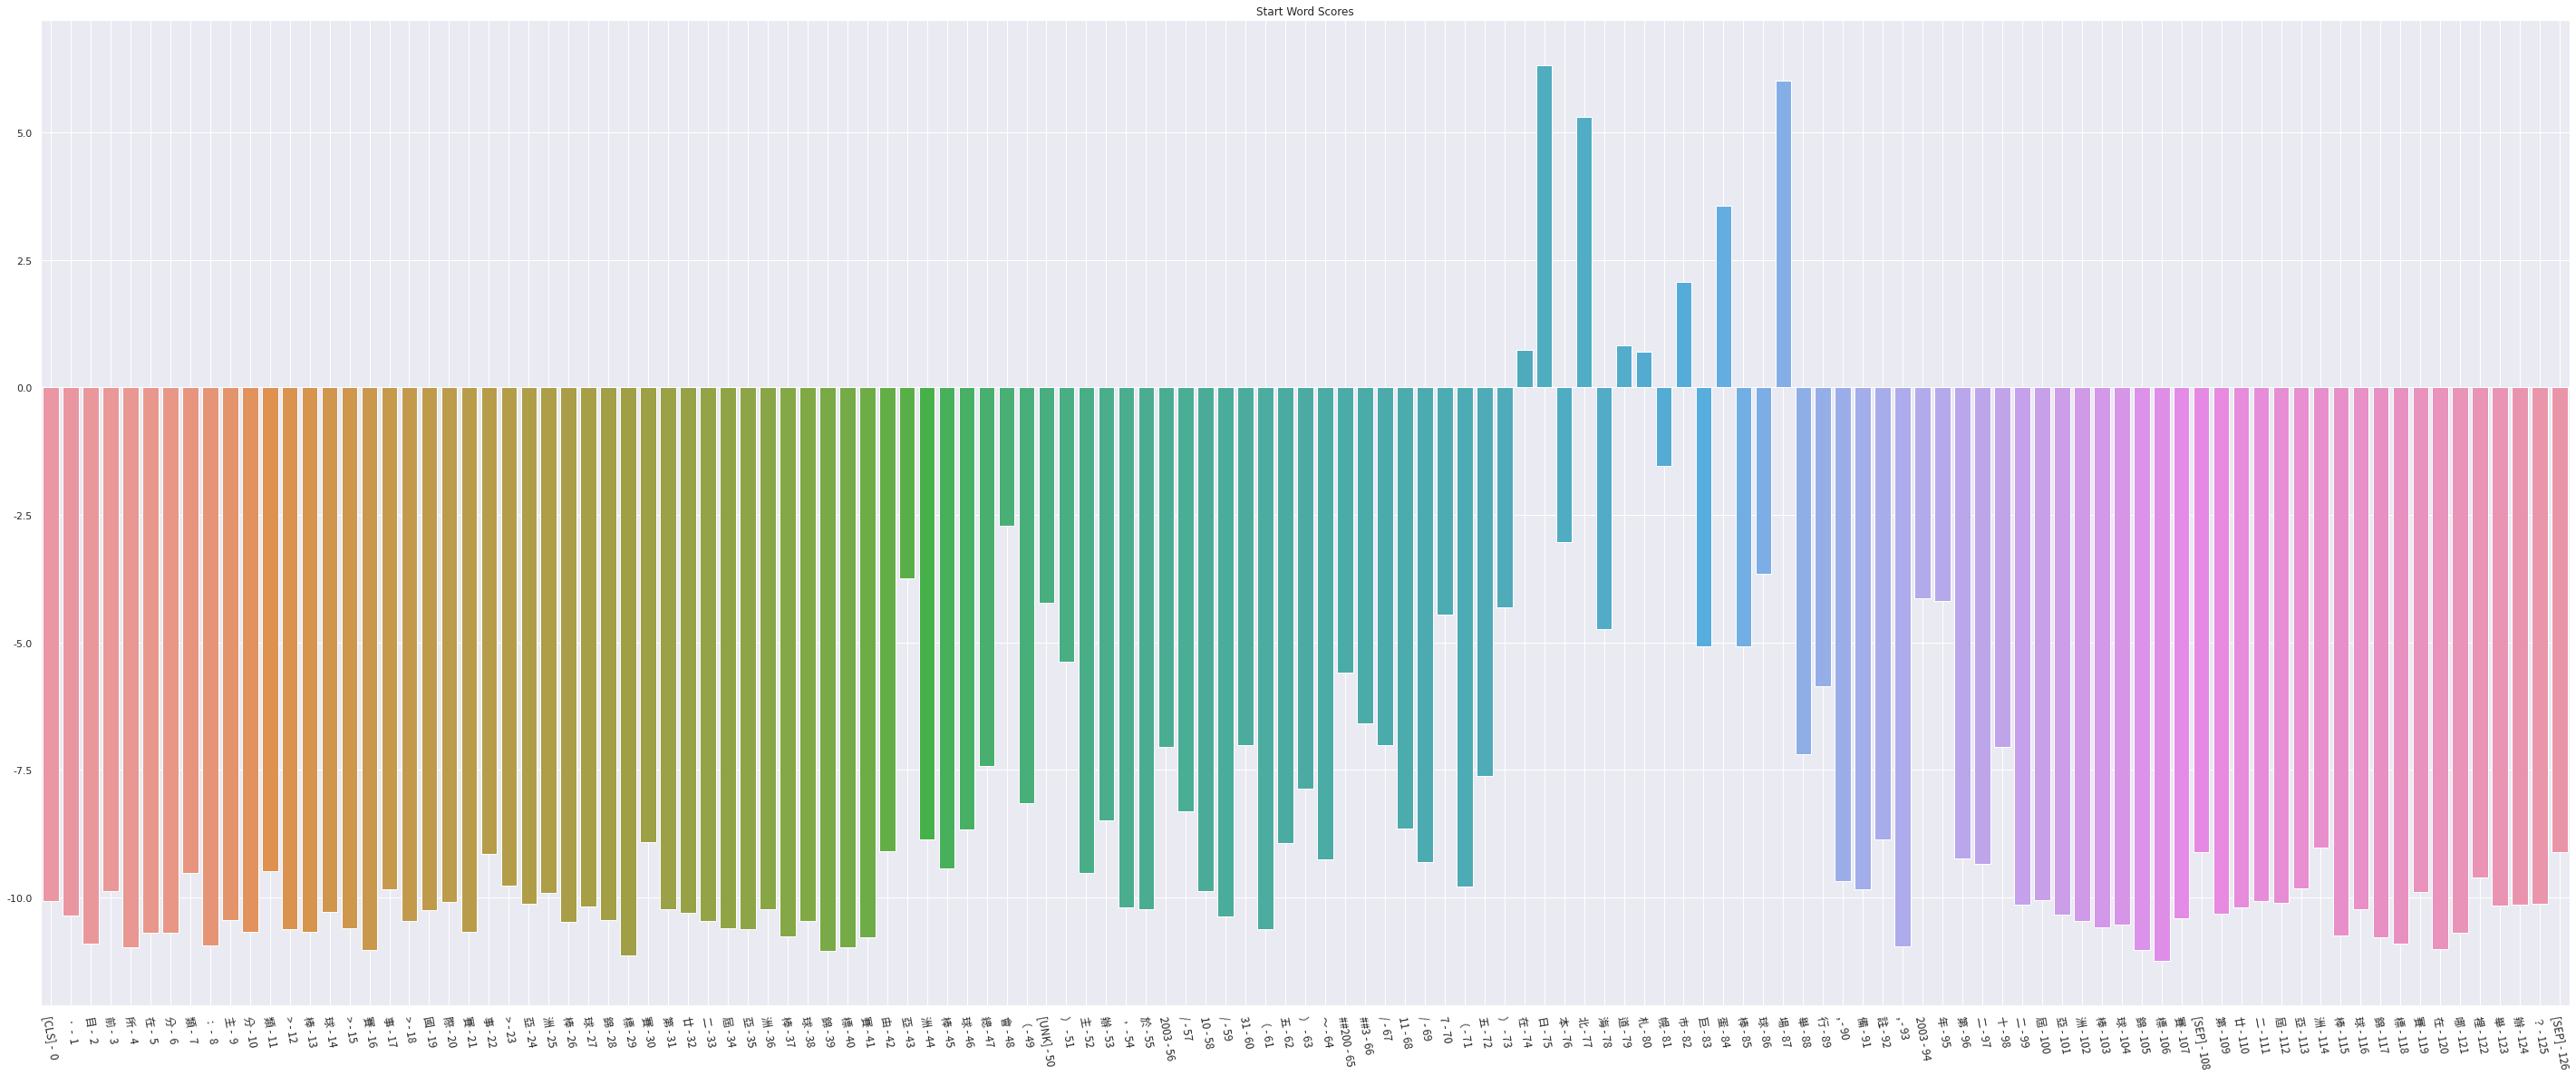

In [ ]:
simpleODQA("第廿二屆亞洲棒球錦標賽在哪裡舉辦？")